In [5]:
import requests
import pandas as pd
from credentials import API_KEY

import ast

import folium
from shapely.geometry import Polygon
import numpy as np
#import geojson
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.wkt
from haversine import haversine, Unit
import time
from pyproj import Geod

from shapely import wkt
from geopandas import  GeoDataFrame, points_from_xy



In [6]:
df_map = pd.read_csv('../data_files/data_set_OK.csv')
df_map.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,GASOLINA EXTRA OXIGENADA,17880.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,BIODIESEL EXTRA,9040.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267


In [7]:
len(df_map)

1293

In [8]:
df_map[['Latitud']].isna().value_counts()

Latitud
False      1281
True         12
Name: count, dtype: int64

In [9]:
df_map.dropna(inplace=True)

In [10]:
df_map.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 0 to 1292
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Periodo              1281 non-null   int64  
 1   Mes                  1281 non-null   int64  
 2   Codigo_departamento  1281 non-null   int64  
 3   Departamento         1281 non-null   object 
 4   Codigo_municipio     1281 non-null   int64  
 5   Municipio            1281 non-null   object 
 6   Nombre_comercial     1281 non-null   object 
 7   Bandera              1281 non-null   object 
 8   Direccion            1281 non-null   object 
 9   Producto             1281 non-null   object 
 10  Precio               1281 non-null   float64
 11  Estado               1281 non-null   object 
 12  Direccion_API        1281 non-null   object 
 13  Latitud              1281 non-null   float64
 14  Longitud             1281 non-null   float64
dtypes: float64(3), int64(4), object(8)
memory u

In [11]:
def get_coords(address,api_key_geocoding):
    
    url_get = f'https://geocode.search.hereapi.com/v1/geocode?q={address}&apiKey={api_key_geocoding}'
    
    try:
        response = requests.get(url=url_get).json()
        clean_address = response['items'][0]['title']
        coord_lat = response['items'][0]['position']['lat']
        coord_lng = response['items'][0]['position']['lng']
        
        results = [clean_address, coord_lat, coord_lng]
    except:
        
        results = ['Not Found', 'NA', 'NA']
    
    return results


def cal_dist(geo_source, point2, unit):
    
    if unit =='Km':
        distance = haversine(geo_source, point2, Unit.KILOMETERS)
    elif unit == 'm':
        distance = haversine(geo_source, point2, Unit.METERS)
    elif unit == 'miles':
        distance = haversine(geo_source, point2, Unit.MILES)
        
    return round(distance,2)


def distance_estac(geo_source, df, radio, unit):
    
    distancia = []
    source = []
    
    for i in range(len(df)):
        distancia.append(cal_dist(geo_source,df['Coordenadas'][i],unit))
        source.append(geo_source)
        
    new_df = df.copy(deep=True)
    new_df['Fuente'] = source
    new_df['Distancia'] = distancia
    new_df = new_df[new_df['Distancia']<=radio]
    new_df = new_df.reset_index()
    new_df = new_df.drop(columns='index')
    
    return new_df.sort_values(by='Distancia', ascending=True)


def transform_df_map(df):
    
    coordenadas = []
    
    for i in range(len(df)):
        
        try: 
            
            coord = float(df['Latitud'][i]), (float(df['Longitud'][i]))
            coordenadas.append(coord)
            
        except :
            
            coordenadas.append('Vacio')
            
    df['Coordenadas'] = coordenadas
    df = df[df['Coordenadas']!='Vacio'] 
    df = df.reset_index()
    df = df.drop(columns = 'index')
    new_df = df.copy()
    
    return new_df
    



In [12]:
df_map.columns

Index(['Periodo', 'Mes', 'Codigo_departamento', 'Departamento',
       'Codigo_municipio', 'Municipio', 'Nombre_comercial', 'Bandera',
       'Direccion', 'Producto', 'Precio', 'Estado', 'Direccion_API', 'Latitud',
       'Longitud'],
      dtype='object')

In [13]:
df_map.drop_duplicates(["Nombre_comercial","Producto"], inplace=True)

# Desarrollo APP

In [14]:
cities=list(df_map['Municipio'].unique())
cities

['MEDELLIN', 'BELLO', 'ENVIGADO', 'ITAGUI', 'RIONEGRO', 'SABANETA']

In [15]:
ciudades_df = df_map[df_map['Municipio']==cities[0]]
ciudades_df.reset_index(inplace=True)
ciudades_df.drop(columns='index', inplace=True)
ciudades_df

/tmp/ipykernel_474/4122221864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ciudades_df.drop(columns='index', inplace=True)


,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,GASOLINA EXTRA OXIGENADA,17880.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,BIODIESEL EXTRA,9040.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267
2,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,GASOLINA CORRIENTE OXIGENADA,9010.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267
3,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO LA AGUACATALA,MOBIL,Carrera 48 No 15 sur 30,GASOLINA EXTRA OXIGENADA,19920.0,A,"Carrera 48 No 15 sur 30, Medellin, Colombia",6.19221,-75.58000
4,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO LA AGUACATALA,MOBIL,Carrera 48 No 15 sur 30,BIODIESEL EXTRA,10610.0,A,"Carrera 48 No 15 sur 30, Medellin, Colombia",6.19221,-75.58000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO INVERSIONES GR SAS,ZEUSS,Carrera 28 No. 59 -7,GASOLINA CORRIENTE OXIGENADA,9486.0,A,"Carrera 28 No. 59 -7, Medellin, Colombia",6.25055,-75.54839
278,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO INVERSIONES GR SAS,ZEUSS,Carrera 28 No. 59 -7,BIODIESEL EXTRA,9244.0,A,"Carrera 28 No. 59 -7, Medellin, Colombia",6.25055,-75.54839
279,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TERPEL PALENQUE,TERPEL,CALLE 68 No. 86 - 26,GASOLINA CORRIENTE OXIGENADA,9423.0,A,"CALLE 68 No. 86 - 26, Medellin, Colombia",6.27831,-75.59463
280,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TERPEL PALENQUE,TERPEL,CALLE 68 No. 86 - 26,GASOLINA EXTRA OXIGENADA,17916.0,A,"CALLE 68 No. 86 - 26, Medellin, Colombia",6.27831,-75.59463


In [16]:
ciudades_df.head(2)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,GASOLINA EXTRA OXIGENADA,17880.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,BIODIESEL EXTRA,9040.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267


In [17]:
locacion = 'CC Premium Plaza, Medellin'
locacion = locacion.replace('#', 'No')
respuesta = get_coords(locacion, API_KEY)
respuesta

['Africa', 6.23011, -75.57027]

In [18]:
geo_source = (respuesta[1], respuesta[2])
geo_source

(6.23011, -75.57027)

In [19]:
radio = 1
unit = 'Km'

In [20]:
m = folium.Map([geo_source[0], geo_source[1]], zoom_start=15)

folium.Circle(
    radius=int(radio)*1000,
    location=[geo_source[0], geo_source[1]],
    color='green',
    fill='green').add_to(m)

folium.Marker(
    location=[geo_source[0], geo_source[1]],
    icon = folium.Icon(
        color='black',
        icon_color='white',
        icon='home',
        prefix='glyphicon'
        ),
    popup="<b>Centro</b>"
    ).add_to(m)

m

In [21]:
ciudades_df = transform_df_map(ciudades_df)
ciudades_df.head(2)

/tmp/ipykernel_474/3385156030.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Coordenadas'] = coordenadas


,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud,Coordenadas
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,GASOLINA EXTRA OXIGENADA,17880.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267,"(6.28685, -75.55267)"
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO TERPEL LA 45,TERPEL,CARRERA 45 No. 66-10,BIODIESEL EXTRA,9040.0,A,"CARRERA 45 No. 66-10, Medellin, Colombia",6.28685,-75.55267,"(6.28685, -75.55267)"


In [22]:
results_df = distance_estac(geo_source, ciudades_df, radio, unit)
results_df.reset_index(inplace=True)
results_df.drop(columns='index', inplace=True)
results_df.head(20)

,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud,Coordenadas,Fuente,Distancia
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO AUTOMOTRIZ COMBUSCOL LA 70,TEXACO,cra70#44-23,BIODIESEL EXTRA,9665.0,A,"cra70No44-23, Medellin, Colombia",6.22804,-75.57211,"(6.22804, -75.57211)","(6.23011, -75.57027)",0.31
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO AUTOMOTRIZ COMBUSCOL LA 70,TEXACO,cra70#44-23,GASOLINA EXTRA OXIGENADA,17300.0,A,"cra70No44-23, Medellin, Colombia",6.22804,-75.57211,"(6.22804, -75.57211)","(6.23011, -75.57027)",0.31
2,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO AUTOMOTRIZ COMBUSCOL LA 70,TEXACO,cra70#44-23,GASOLINA CORRIENTE OXIGENADA,9577.0,A,"cra70No44-23, Medellin, Colombia",6.22804,-75.57211,"(6.22804, -75.57211)","(6.23011, -75.57027)",0.31
3,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TEXACO NUEVAS PALMAS,TEXACO,Carrera 38 No 26 - 259,BIODIESEL EXTRA,9702.0,A,"Carrera 38 No 26 - 259, Medellin, Colombia",6.22652,-75.56506,"(6.22652, -75.56506)","(6.23011, -75.57027)",0.70
4,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TEXACO NUEVAS PALMAS,TEXACO,Carrera 38 No 26 - 259,GASOLINA CORRIENTE OXIGENADA,9714.0,A,"Carrera 38 No 26 - 259, Medellin, Colombia",6.22652,-75.56506,"(6.22652, -75.56506)","(6.23011, -75.57027)",0.70
5,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TEXACO NUEVAS PALMAS,TEXACO,Carrera 38 No 26 - 259,GASOLINA EXTRA OXIGENADA,17724.0,A,"Carrera 38 No 26 - 259, Medellin, Colombia",6.22652,-75.56506,"(6.22652, -75.56506)","(6.23011, -75.57027)",0.70
6,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO APOLO CON AUTOPISTA SUR S...,TERPEL,CARRERA 50 No. 2 SUR-189,GASOLINA EXTRA OXIGENADA,17690.0,A,"CARRERA 50 No. 2 SUR-189, Medellin, Colombia",6.23583,-75.57355,"(6.23583, -75.57355)","(6.23011, -75.57027)",0.73
7,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO APOLO CON AUTOPISTA SUR S...,TERPEL,CARRERA 50 No. 2 SUR-189,BIODIESEL EXTRA,8880.0,A,"CARRERA 50 No. 2 SUR-189, Medellin, Colombia",6.23583,-75.57355,"(6.23583, -75.57355)","(6.23011, -75.57027)",0.73
8,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO APOLO CON AUTOPISTA SUR S...,TERPEL,CARRERA 50 No. 2 SUR-189,GASOLINA CORRIENTE OXIGENADA,9150.0,A,"CARRERA 50 No. 2 SUR-189, Medellin, Colombia",6.23583,-75.57355,"(6.23583, -75.57355)","(6.23011, -75.57027)",0.73
9,2022,6,5,ANTIOQUIA,5001,MEDELLIN,JUANBE SAN DIEGO,TEXACO,Calle 37 No. 44-11,GASOLINA CORRIENTE OXIGENADA,9660.0,A,"Calle 37 No. 44-11, Medellin, Colombia",6.23682,-75.56950,"(6.23682, -75.5695)","(6.23011, -75.57027)",0.75


In [23]:
gdf_results = GeoDataFrame(results_df, geometry=points_from_xy(results_df['Latitud'],results_df['Longitud']))

In [24]:
gdf_results.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Periodo              15 non-null     int64   
 1   Mes                  15 non-null     int64   
 2   Codigo_departamento  15 non-null     int64   
 3   Departamento         15 non-null     object  
 4   Codigo_municipio     15 non-null     int64   
 5   Municipio            15 non-null     object  
 6   Nombre_comercial     15 non-null     object  
 7   Bandera              15 non-null     object  
 8   Direccion            15 non-null     object  
 9   Producto             15 non-null     object  
 10  Precio               15 non-null     float64 
 11  Estado               15 non-null     object  
 12  Direccion_API        15 non-null     object  
 13  Latitud              15 non-null     float64 
 14  Longitud             15 non-null     float64 
 15  Coordenadas      

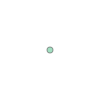

In [25]:
gdf_results['geometry'][0]

In [26]:
lista_tipos=list(gdf_results['Producto'].unique())
lista_tipos

['BIODIESEL EXTRA', 'GASOLINA EXTRA OXIGENADA', 'GASOLINA CORRIENTE OXIGENADA']

In [27]:
gdf_results_2 = gdf_results[gdf_results['Producto']==lista_tipos[2]]
gdf_results_2.reset_index(inplace=True)
gdf_results_2.drop(columns='index', inplace=True)
gdf_results_2

/tmp/ipykernel_474/331839157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_results_2.drop(columns='index', inplace=True)


,Periodo,Mes,Codigo_departamento,Departamento,Codigo_municipio,Municipio,Nombre_comercial,Bandera,Direccion,Producto,Precio,Estado,Direccion_API,Latitud,Longitud,Coordenadas,Fuente,Distancia,geometry
0,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO AUTOMOTRIZ COMBUSCOL LA 70,TEXACO,cra70#44-23,GASOLINA CORRIENTE OXIGENADA,9577.0,A,"cra70No44-23, Medellin, Colombia",6.22804,-75.57211,"(6.22804, -75.57211)","(6.23011, -75.57027)",0.31,POINT (6.22804 -75.57211)
1,2022,6,5,ANTIOQUIA,5001,MEDELLIN,TEXACO NUEVAS PALMAS,TEXACO,Carrera 38 No 26 - 259,GASOLINA CORRIENTE OXIGENADA,9714.0,A,"Carrera 38 No 26 - 259, Medellin, Colombia",6.22652,-75.56506,"(6.22652, -75.56506)","(6.23011, -75.57027)",0.70,POINT (6.22652 -75.56506)
2,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIO APOLO CON AUTOPISTA SUR S...,TERPEL,CARRERA 50 No. 2 SUR-189,GASOLINA CORRIENTE OXIGENADA,9150.0,A,"CARRERA 50 No. 2 SUR-189, Medellin, Colombia",6.23583,-75.57355,"(6.23583, -75.57355)","(6.23011, -75.57027)",0.73,POINT (6.23583 -75.57355)
3,2022,6,5,ANTIOQUIA,5001,MEDELLIN,JUANBE SAN DIEGO,TEXACO,Calle 37 No. 44-11,GASOLINA CORRIENTE OXIGENADA,9660.0,A,"Calle 37 No. 44-11, Medellin, Colombia",6.23682,-75.56950,"(6.23682, -75.5695)","(6.23011, -75.57027)",0.75,POINT (6.23682 -75.56950)
4,2022,6,5,ANTIOQUIA,5001,MEDELLIN,ESTACION DE SERVICIOS DISTRACOM EXPOSICIONES,TEXACO,CALLE 36 No. 51-18,GASOLINA CORRIENTE OXIGENADA,9030.0,A,"CALLE 36 No. 51-18, Medellin, Colombia",6.23779,-75.57378,"(6.23779, -75.57378)","(6.23011, -75.57027)",0.94,POINT (6.23779 -75.57378)


In [28]:
gdf_results_2['Precio'].max()

9714.0

In [32]:
len(gdf_results_2.index)

5

In [29]:
def graph_gas_station(gdf,tipo_producto,icono, unit,mapa):
    
    df_nuevo = gdf[gdf['Producto']==tipo_producto]
    df_nuevo.reset_index(inplace=True)
    df_nuevo.drop(columns='index', inplace=True)
    print(df_nuevo['Precio'].min())

    for i in range(len(df_nuevo)):
        
        if df_nuevo['Precio'][i] == df_nuevo['Precio'].min():
            
            html =  f"""<b>MARCA:</b> {df_nuevo.Bandera[i]} <br>
                    <b>NOMBRE:</b> {df_nuevo.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df_nuevo.Producto[i]} <br>
                    <b>PRECIO:</b> {df_nuevo.Precio[i]} <br>
                    <b>DISTANCIA:</b> {df_nuevo.Distancia[i]} <br>
                    <b>UNIDAD:</b> {unit} <br>
                    <b>DIRECCION:</b> {df_nuevo.Direccion[i]} <br>"""
            iframe = folium.IFrame(html=html, figsize=(6,3))
            popup = folium.Popup(iframe)
            
            folium.Marker(location=[float(df_nuevo['Latitud'][i]), float(df_nuevo['Longitud'][i])],
                        icon = folium.Icon(
                            color='darkgreen',
                            icon_color='white',
                            icon=icono,
                            prefix='glyphicon'),
                        popup=popup).add_to(mapa)
        
        elif df_nuevo['Precio'][i] == df_nuevo['Precio'].max():
            
            html =  f"""<b>MARCA:</b> {df_nuevo.Bandera[i]} <br>
                    <b>NOMBRE:</b> {df_nuevo.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df_nuevo.Producto[i]} <br>
                    <b>PRECIO:</b> {df_nuevo.Precio[i]} <br>
                    <b>DISTANCIA:</b> {df_nuevo.Distancia[i]} <br>
                    <b>UNIDAD:</b> {unit} <br>
                    <b>DIRECCION:</b> {df_nuevo.Direccion[i]} <br>"""
            iframe = folium.IFrame(html=html, figsize=(6,3))
            popup = folium.Popup(iframe)
            
            folium.Marker(location=[float(df_nuevo['Latitud'][i]), float(df_nuevo['Longitud'][i])],
                        icon = folium.Icon(
                            color='darkred',
                            icon_color='white',
                            icon=icono,
                            prefix='glyphicon'),
                        popup=popup).add_to(mapa)
        
        else:
            
            html =  f"""<b>MARCA:</b> {df_nuevo.Bandera[i]} <br>
                    <b>NOMBRE:</b> {df_nuevo.Nombre_comercial[i]} <br>
                    <b>PRODUCTO:</b> {df_nuevo.Producto[i]} <br>
                    <b>PRECIO:</b> {df_nuevo.Precio[i]} <br>
                    <b>DISTANCIA:</b> {df_nuevo.Distancia[i]} <br>
                    <b>UNIDAD:</b> {unit} <br>
                    <b>DIRECCION:</b> {df_nuevo.Direccion[i]} <br>"""
            iframe = folium.IFrame(html=html, figsize=(6,3))
            popup = folium.Popup(iframe)
            
            folium.Marker(location=[float(df_nuevo['Latitud'][i]), float(df_nuevo['Longitud'][i])],
                        icon = folium.Icon(
                            color='orange',
                            icon_color='white',
                            icon=icono,
                            prefix='glyphicon'),
                        popup=popup).add_to(mapa)
            
    return
    

In [30]:
graph_gas_station(gdf_results,lista_tipos[0],'usd', unit, mapa=m)
m

/tmp/ipykernel_474/1960718173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuevo.drop(columns='index', inplace=True)
